# GITHUB REPO

https://github.com/ArturTan/unsupervised-algorithms-in-machine-learning-week-4

# Kaggle imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv
/kaggle/input/stopwords/stopwords-en.txt


# Imports

In [2]:
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm, trange
import nltk
from nltk.corpus import stopwords
import string 
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
import itertools
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import nltk
import sys
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px

/tmp/ipykernel_4341/481458356.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## EDA

In [3]:
data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")

Let's examine the data by checking the length of the texts.

In [4]:
data['length'] = data['Text'].str.len()

<Axes: >

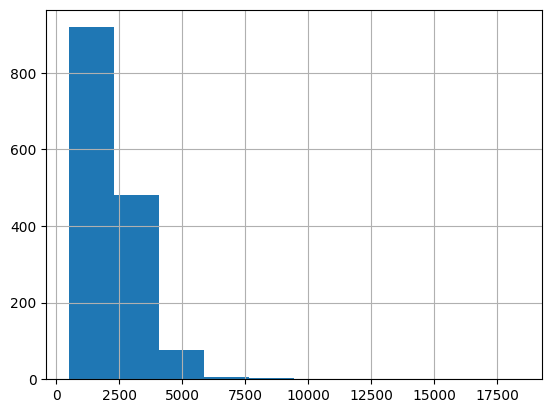

In [5]:
data['length'].hist()

Some "outliers" have more than 5,000 words. Let's remove them, as they may contaminate the results and add too many dimensions to account for.

In [6]:
# remove outliers
data = data[np.logical_and(data['length'] < 5000, data['length'] > 0)]

In [7]:
data

,ArticleId,Text,Category,length
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866
1,154,german business confidence slides german busin...,business,2016
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104
3,1976,lifestyle governs mobile choice faster bett...,tech,3618
4,917,enron bosses in $168m payout eighteen former e...,business,2190
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1266
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3111
1487,1590,weak dollar hits reuters revenues at media gro...,business,1370
1488,1587,apple ipod family expands market apple has exp...,tech,3242


There are now 1,490 records and four columns. The most interesting ones are the text and category columns. Let's check how many items are in each category.

<Axes: xlabel='Category'>

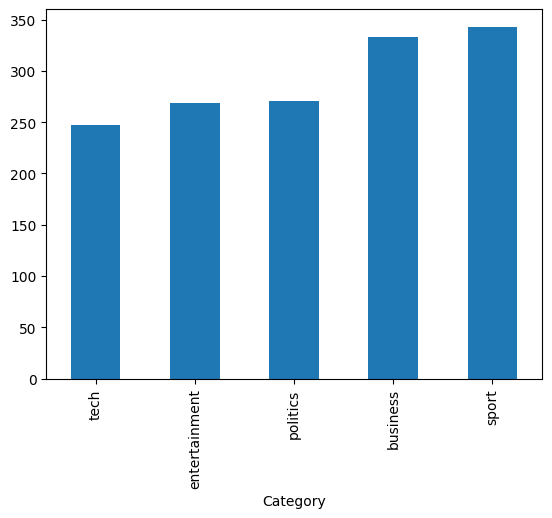

In [8]:
data.Category.value_counts().sort_values().plot(kind = 'bar')

The data is distributed uniformly, meaning that oversampling will not be needed.

One of the interesting features to consider is that each topic should contain slightly different words.

In [9]:
@dataclass
class VectorizerData:
    ngram: int
    category: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [10]:
with open("/kaggle/input/stopwords/stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

train_data = data
    
def get_top_ngram(category=None, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    if category:
        data = train_data[train_data.Category == category]
    else:
        data = train_data
    bag_of_words = vectorizer.fit_transform(data['Text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return VectorizerData(ngram = n, category=category, vectorizer=vectorizer, sum_words=sum_words, words_freq=words_freq)

business


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


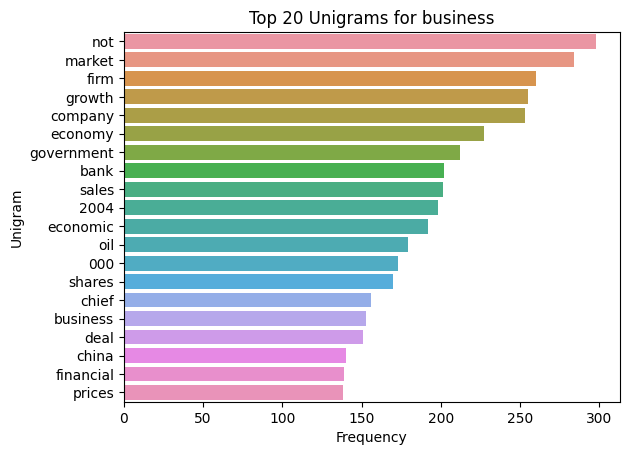

tech


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


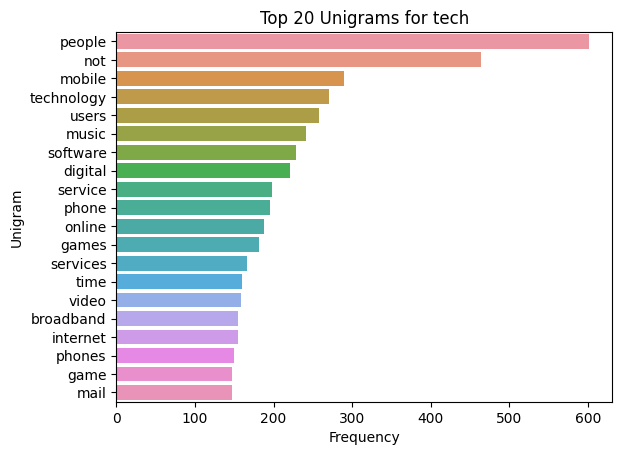

politics


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


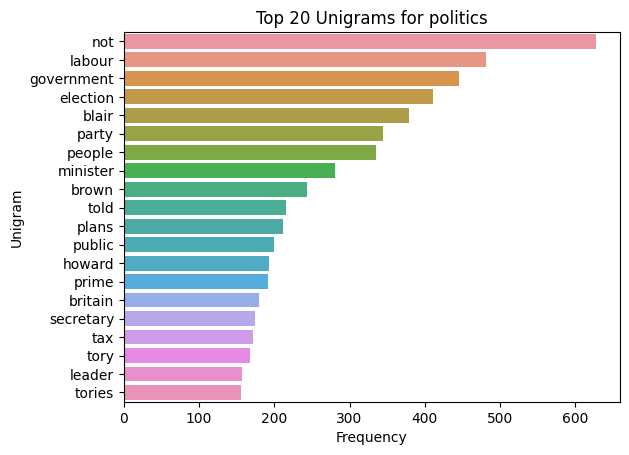

sport


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


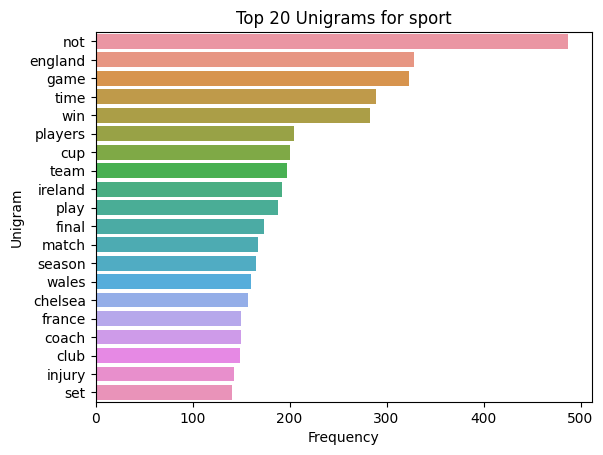

entertainment


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


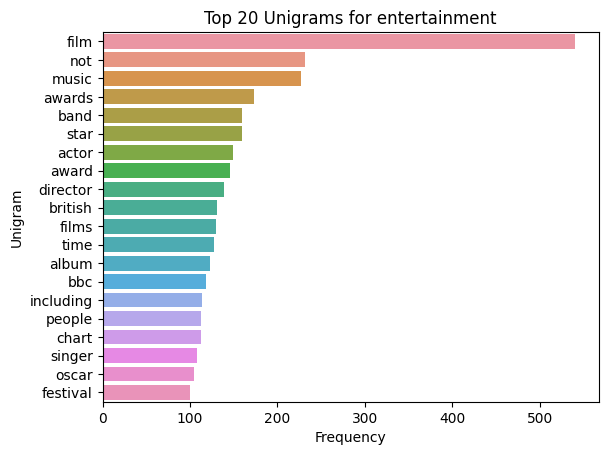

In [11]:
for category in data.Category.unique():
    print(category)
    ngram_data = get_top_ngram(category, 1)
    x, y = map(list, zip(*ngram_data.words_freq[:20]))
    
    plt.figure()
    sns.barplot(x=y, y=x)
    plt.title(f"Top 20 Unigrams for {category}") 
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.show()

There is nothing unexpected in these diagrams; it appears that all the topics differ from each other based on the most popular words.

## Preprocessing

The goal is to prepare the data for further training

First, we download a set of common English stopwords using the `nltk` library and combines these with standard punctuation symbols to create a comprehensive list of unwanted tokens (referred to as `stop_words`). Next, the code initializes a `CountVectorizer` using this updated list of stop words to transform the text data into a matrix of token counts. However, only those words with a frequency greater than one are retained. 

The script then separates the frequent and infrequent words into two lists: `keep_words` for words with a frequency higher than one and `new_stop_words` for less frequent words. Additionally, any words consisting solely of digits are removed from `keep_words`. 

This comprehensive preprocessing step ensures that the resultant text data is cleaner, focusing on the most meaningful and frequently occurring words while removing noise from the dataset, thereby improving the performance of subsequent text analysis or machine learning tasks. 

In [12]:

nltk.download('stopwords')
word_list = list(stopwords.words('english'))

stop_words = [word for word in word_list]
stop_words += [punct for punct in string.punctuation]
vectorizer = CountVectorizer(stop_words=stop_words)
cv_fit = vectorizer.fit_transform(train_data.Text)
words = np.asarray(cv_fit.sum(axis=0))

id2word = { id : word for word, id in vectorizer.vocabulary_.items()}

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Remove the words that occur more than 1
condition_range = words[0] > 1

new_stop_words = []
for i in np.argwhere(~condition_range):
    new_stop_words.append(id2word[i[0]])

keep_words = []
for i in np.argwhere(condition_range):
    keep_words.append(id2word[i[0]])

# Remove digits
digit_pattern = re.compile('\d+')

keep_words = set([word for word in keep_words if not digit_pattern.search(word)])

print(len(new_stop_words), len(keep_words))

text_lemmatized = [" ".join([word.lower() for word in text.split() if word.lower() in keep_words]) for text in train_data.Text ]

train_data['text_lematized'] = text_lemmatized


8607 14538


Finally, we will use the TFIDF vectorizer as a simple encoder (note: it's not a real transformer) to feed arrays into the model that will be trained as the predictor. For supervised learning, we will use Logistic Regression, and for unsupervised learning, we will use NMF.

The Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is a statistical tool utilized in natural language processing and information retrieval to assess the significance of a word within a document relative to a larger set of documents, known as a corpus. It is often used to convert text data into numerical vectors that can serve as input for machine learning models.

How does it work? We need to understand two terms:

- **Term Frequency (TF)**: How frequently a term appears in a document.
- **Inverse Document Frequency (IDF)**: Reduces the significance of words that are common across all documents.

The process is as follows:

1. The text is broken down into words (tokens), typically converted to lowercase, and common stop words may be removed.
2. For each term in each document, compute the term frequency.
3. Compute the IDF value for each term across the entire corpus.
4. Multiply the TF value by the IDF value for each term, forming a vector for each document.

In [14]:
vectorizer = TfidfVectorizer(stop_words=stop_words + new_stop_words)
cv_fit = vectorizer.fit_transform(text_lemmatized)

# Hyperparameter search (logistic regression and NMF)

## Splitting the dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(cv_fit, train_data['Category'], stratify=train_data['Category'], test_size=.20)


# Hyperparameter search

We need to create a custom model that can be used with the GridSearchCV class.

This is a snippet reused from the Clustering Assignment in Week 2. It reassigns the found labels into the categories

In [28]:
class GridLikeNMF(NMF):
    
    def fit(self, X, y, *args, **kwargs):
        results = super().fit_transform(X, *args, **kwargs)
        self.labelorder, acc = label_permute_compare(y, results.argmax(axis=1))
    
    def predict(self, X):
        test_results = self.transform(X)
        return np.vectorize(lambda x: self.labelorder(x)[0])(test_results.argmax(axis=1))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [29]:
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    label_encoder = LabelEncoder()
    yt_transformed = label_encoder.fit_transform(ytdf)
    cost_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            cost_matrix[i, j] = np.sum((yt_transformed == i) & (yp != j))
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = {old_label: new_label for old_label, new_label in zip(col_ind, row_ind)} 
    yp_permuted = [label_encoder.inverse_transform([label_mapping.get(x)]) for x in yp]
    accuracy = accuracy_score(ytdf, yp_permuted)
    original_labels = label_encoder.inverse_transform(col_ind)
    new_labels_order = [label_encoder.inverse_transform([label_mapping.get(x)]) for x in yp]
    permuted_labels = tuple(original_labels[i] for i in row_ind)
    return lambda x : label_encoder.inverse_transform([label_mapping.get(x)]), accuracy


## Searching for parameters

What is most important here is that I set CV to 2 because NMF needs as much data as possible. It seems to underperform when CV is set to 3 or more folds.

In [30]:
def create_param_grids():
    param_grids = {
        'custom_nmf': dict(
                init = ['random', 'nndsvd', 'nndsvda', 'nndsvdar', 'custom'],
        solver = [
            'cd', 'mu'],
        beta_loss = ["frobenius", "kullback-leibler", "itakura-saito"] ,
        alpha_W = [0.01, 0.1, 1.0, 10, 100]

        ),
        'log_reg': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear'],
        },
    }
    return param_grids

def create_models():
    models = {
        'log_reg': LogisticRegression(n_jobs=5),
        'custom_nmf': GridLikeNMF(n_components=5)
    }
    return models

def search_best_params(cv, models, param_grids):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Performing Grid Search for {model_name}...")
        grid_search = GridSearchCV(model, param_grids[model_name], scoring='f1_weighted', cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = {}
        best_estimators[model_name]["model_params"] = grid_search.best_params_
        best_estimators[model_name]["f1_score"] = grid_search.best_score_
        best_estimators[model_name]["model"] = grid_search.best_estimator_
        
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best F1 Score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
models = create_models()
param_grids = create_param_grids()
best_estimators = search_best_params(cv, models, param_grids)

Performing Grid Search for log_reg...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 5.
  

Best parameters for log_reg: {'C': 10, 'solver': 'liblinear'}
Best F1 Score for log_reg: 0.95367450286084

Performing Grid Search for custom_nmf...


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1524: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packag

Best parameters for custom_nmf: {'alpha_W': 0.1, 'beta_loss': 'kullback-leibler', 'init': 'nndsvdar', 'solver': 'mu'}
Best F1 Score for custom_nmf: 0.9390873887815626



In [31]:
best_estimators

{'log_reg': {'model_params': {'C': 10, 'solver': 'liblinear'},
  'f1_score': 0.95367450286084,
  'model': LogisticRegression(C=10, n_jobs=5, solver='liblinear')},
 'custom_nmf': {'model_params': {'alpha_W': 0.1,
   'beta_loss': 'kullback-leibler',
   'init': 'nndsvdar',
   'solver': 'mu'},
  'f1_score': 0.9390873887815626,
  'model': GridLikeNMF(alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvdar',
              n_components=5, solver='mu')}}

In [32]:
for model_name in best_estimators:
    model = best_estimators[model_name]['model']
    y_hat = model.predict(X_test)
    print(confusion_matrix(y_test, y_hat))

[[65  0  1  0  1]
 [ 0 54  0  0  0]
 [ 1  0 52  1  0]
 [ 0  0  0 69  0]
 [ 1  1  0  1 46]]
[[61  0  4  0  2]
 [ 0 53  0  0  1]
 [ 2  1 51  0  0]
 [ 0  0  0 69  0]
 [ 0  2  2  0 45]]


## Final Training

### Supervised model

In [33]:
model = LogisticRegression(**best_estimators['log_reg']['model_params'])
model.fit(X_train, y_train)
print("F1 score for train set: ", f1_score(y_train, model.predict(X_train), average='macro'))
print("F1 score for test set: ", f1_score(y_test, model.predict(X_test), average='macro'))

confusion_matrix(y_test, model.predict(X_test))

F1 score for train set:  1.0
F1 score for test set:  0.9753970355349573


array([[65,  0,  1,  0,  1],
       [ 0, 54,  0,  0,  0],
       [ 1,  0, 52,  1,  0],
       [ 0,  0,  0, 69,  0],
       [ 1,  1,  0,  1, 46]])

### Unsupervised model

In [34]:
best_estimators['custom_nmf']['model_params']

{'alpha_W': 0.1,
 'beta_loss': 'kullback-leibler',
 'init': 'nndsvdar',
 'solver': 'mu'}

In [35]:
model = GridLikeNMF(n_components=5, **best_estimators['custom_nmf']['model_params'])
model.fit(X_train, y_train)
print("F1 score for train set: ", f1_score(y_train, model.predict(X_train), average='macro'))
print("F1 score for test set: ", f1_score(y_test, model.predict(X_test), average='macro'))
confusion_matrix(y_test, model.predict(X_test))

F1 score for train set:  0.9461005274046913
F1 score for test set:  0.9497703745126426


array([[61,  0,  4,  0,  2],
       [ 0, 53,  0,  0,  1],
       [ 2,  1, 51,  0,  0],
       [ 0,  0,  0, 69,  0],
       [ 0,  2,  2,  0, 45]])

## Submission data

In [36]:
test_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
text_lemmatized = [" ".join([word.lower() for word in text.split() if word.lower() in keep_words]) for text in test_data.Text ]
test_data['text_lematized'] = text_lemmatized
ref = vectorizer.transform(text_lemmatized)

In [25]:
results = best_estimators['custom_nmf']['model'].predict(ref)

In [26]:
test_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")

In [27]:
test_data['Category']  = results
test_data.to_csv("submission.csv", index=0)

# Discussion and results

I've got 0.95 results with the unsupervised learning algorithm:

![alt text](artur-tanona-results.png "Title")


We observe that the supervised model (logistic regression) performs better than the unsupervised model (NMF), but the margin of improvement is less than anticipated. 
The dataset may be too small, resulting in overfitting in the logistic regression model and reducing its generalizability.
In contrast, NMF, as a dimensionality reduction technique, might more effectively capture the latent structures within the data, leading to better-than-expected performance despite being an unsupervised model.

# Reference

* https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* https://machinelearningmastery.com/logistic-regression-for-machine-learning/ 
* https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/